# Disappearing Forests - Milestone 2


## Introduction
In this notebook, we would try to answer these research questions using our data analysis skills. To do so, we set up some goals to achieve:
- Identify the trend of deforestation in the world
- Find the most deforested countries/areas
- Search for positive examples between countries in terms of deforestation
- Investigate the deforestation in the most forested countries
- Find the biggest producers of wood and investigate the impact of wood mining on deforestation
- Look for the biggest importers/exporters (countries) in the world and the connections among them
- Search for correlations between agriculture industry/animal husbandry and deforestation

## Data Preprocessing
The initial preprocessing of the data was using __Shell__. The script used for preprocessing the normalized datasets from __FAOSTAT__ can be found in `data/faostat/clean_me.sh`. Here is the list of the datasets that we would work on.

- `Inputs_LandUse_E_All_Data_cleared.csv`
- `Environment_LandCover_E_All_Data_cleared.csv`
- `Environment_LandUse_E_All_Data_cleared.csv`
- `Environment_LivestockPatterns_E_All_Data_cleared.csv`
- `Forestry_E_All_Data_cleared.csv`
- `Forestry_Trade_Flows_E_All_Data_cleared.csv`
- `FAOSTAT_countries.csv`

In [1]:
# all the necessary imports
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer
from bokeh.io import curdoc, output_notebook, export_png
from bokeh.models import Slider, HoverTool
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from bokeh.layouts import widgetbox, row, column
import geopandas as gpd
import json

warnings.filterwarnings('ignore')
%matplotlib inline
sns.set()

In [2]:
# FAOSTAT are splitted into multiple groups
# FAOSTAT_countries consists of names of the countries
# FAOSTAT_country_groups consists of bigger regions, such as (Europe, Americas, East Europe etc.)
FAOSTAT_country_data = pd.read_csv("data/faostat/FAOSTAT_countries.csv", engine='python')
FAOSTAT_country_groups = FAOSTAT_country_data["Country Group"].unique()
FAOSTAT_countries = FAOSTAT_country_data["Country"].unique()
CONTINENTS = ['Africa', 'Asia', 'Oceania', 'Europe', 'Northern America', 'South America', 'Antarctic Region']

## 1. The Deforestation Trend
In this section, we try to explore in the data set `Inputs_LandUse_E_All_Data_cleared.csv` to find out related information about forestation and deforestation in each country. Ultimately, we would like to figure out the trend of deforestation over the time span in each country.

### Forests in each country
In this part, we would dive into the dataset `Inputs_LandUse_E_All_Data_cleared.csv` to see forest situation in the nations around the globe, intending to compare the distribution among them.

In [3]:
# select forestation related features from Inputs_LandUse 
LAND_USE_FOREST_ITEMS = ['Forestry']

land_use_all = pd.read_csv("data/faostat/Inputs_LandUse_E_All_Data_cleared.csv", engine='python')
land_use = land_use_all[land_use_all.Item.isin(LAND_USE_FOREST_ITEMS) &
                        land_use_all.Element.str.match('Area')]

# change Area USSR to Russian Federation
land_use.Area = np.where(land_use['Area'] == 'USSR', 'Russian Federation', land_use.Area)

In [4]:
# foreseted areas (ha) for every contry per year
forested_area_yearly = land_use[land_use.Area.isin(FAOSTAT_countries)].groupby(["Area", "Year"]).Value.sum()
forested_area_yearly_unstack = forested_area_yearly.unstack("Year")

Here we present top 5 countries' forestation status (those having top 5 most important forestation matching to the record in [**Wiki**](https://en.wikipedia.org/wiki/List_of_countries_by_forest_area)). Specifically, we would take a look at their forest areas from 1990 to 2017.

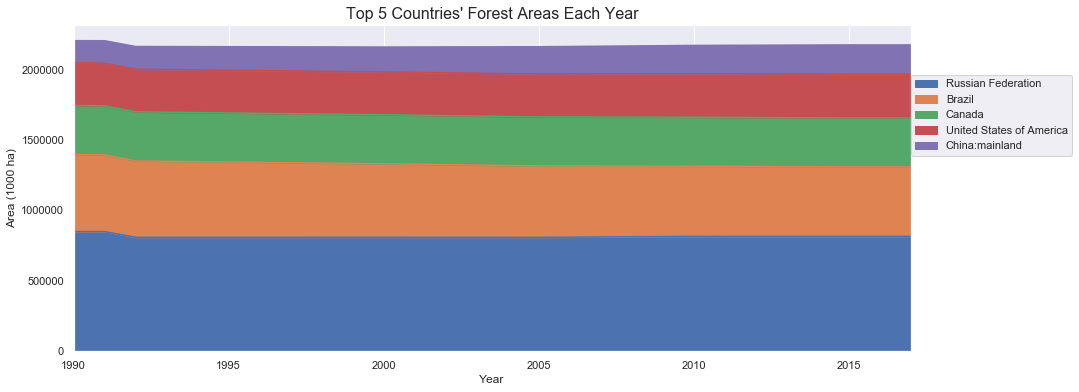

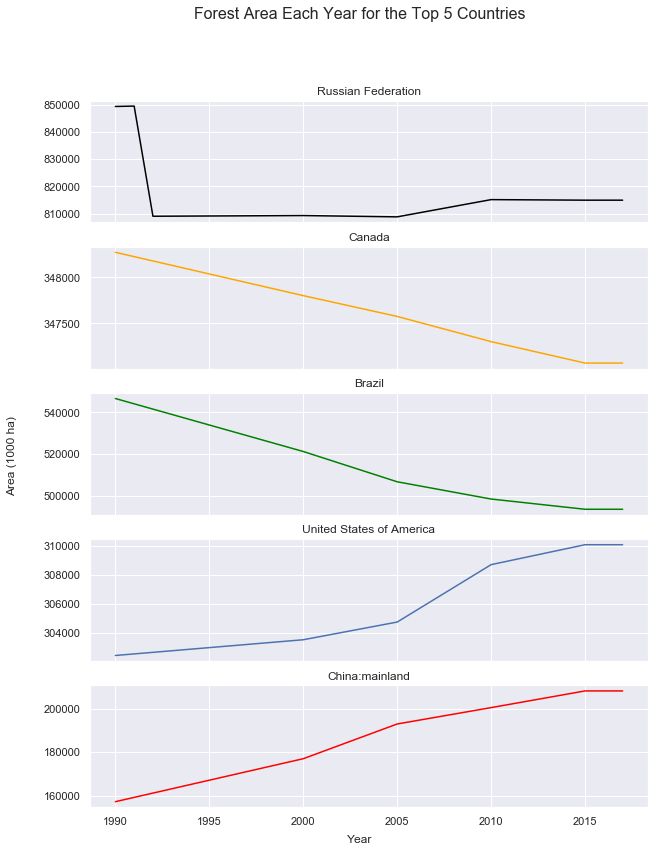

In [5]:
# plot the forest area of top 5 countries containing most important forestation 
forested_area_yearly_unstack.loc[['Russian Federation', 'Brazil', 'Canada', 'United States of America', 'China:mainland'], :]\
                            .T.plot.area(figsize = (15, 6))
plt.legend(loc = (1, 0.6))
plt.ylabel('Area (1000 ha)')
plt.title("Top 5 Countries' Forest Areas Each Year", fontsize = 16)
plt.show()

# look in more detailed for those top 5
fig, axes = plt.subplots(5, 1, sharex = True, figsize = (10, 13))
axes[0].plot(forested_area_yearly.loc['Russian Federation'], color = 'black')
axes[1].plot(forested_area_yearly.loc['Canada'], color = 'orange')
axes[2].plot(forested_area_yearly.loc['Brazil'], color = 'green')
axes[3].plot(forested_area_yearly.loc['United States of America'])
axes[4].plot(forested_area_yearly.loc['China:mainland'], color = 'red')
axes[0].set_title('Russian Federation')
axes[1].set_title('Canada')
axes[2].set_title('Brazil')
axes[3].set_title('United States of America')
axes[4].set_title('China:mainland')
fig.suptitle("Forest Area Each Year for the Top 5 Countries", fontsize = 16)
fig.text(0.5, 0.087, 'Year', ha = 'center', fontsize = 12)
fig.text(0.01, 0.5, 'Area (1000 ha)', va = 'center', rotation = 'vertical', fontsize = 12)
plt.show()

> #### ***Explanation***
- As we can see in the plot, both Brazil and Canada have decreasing forest areas in every coming year.
- On the contrary, USA and China respectively have the postive trend of increasing forest areas.
- As for Russia, we can see that there is a sudden drop from 1990, which may result from dissolution of Soviet Union and reduce the forest areas in Russia. Reference is [**here**](https://en.wikipedia.org/wiki/Dissolution_of_the_Soviet_Union)

Overall, to get the clearer observation, we would like to present the world map to show forest area of countries. Take the recent year in 2016 as an example.  

In [8]:
# load county codes and adjust missing values
coutry_codes = FAOSTAT_country_data[["Country", "ISO3 Code"]].drop_duplicates()
coutry_codes.loc[coutry_codes.Country.str.match("China:mainland"), "Country"] = "China"
coutry_codes.loc[coutry_codes.Country.str.match("China:mainland"), "ISO3 Code"] = "SDN"

# load 'Environment_LandUse_E_All_Data_cleared.csv' data set and filter columns
env_land_use_all = pd.read_csv("data/faostat/Environment_LandUse_E_All_Data_cleared.csv", engine='python')
env_land_use = env_land_use_all[env_land_use_all.Item.isin(['Forest land']) & env_land_use_all.Element.str.match("Share in Land area")][["Area", "Year", "Value"]]

# join the codes to the countires
env_land_use = env_land_use.merge(coutry_codes, how='left', left_on='Area', right_on='Country').drop('Country', axis=1)

# load shapes of the countries and load it to Geopandas
shapefile = 'data/map/ne_110m_admin_0_countries.shp'

# rename columns and drop Antarctica
gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
gdf.columns = ['country', 'country_code', 'geometry']
gdf = gdf.drop(gdf.index[159])

# select the most recent year in the data set
env_land_use_2016 = env_land_use[env_land_use['Year'] == 2016]

# merge dataframes gdf and env_land_use_2016
merged = gdf.merge(env_land_use_2016, left_on = 'country_code', right_on = 'ISO3 Code', how = 'left')

# read data to json and convert to String like object
merged_json = json.loads(merged.to_json())
json_data = json.dumps(merged_json)

# input GeoJSON source that contains features for plotting
geosource = GeoJSONDataSource(geojson = json_data)
# define a sequential multi-hue color palette.
palette = brewer['YlGn'][8]
# reverse color order
palette = palette[::-1]
# instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 70)
# define custom tick labels for color bar.
tick_labels = {'0': '0%', '5': '5%', '10':'10%', '15':'15%', '20':'20%', '25':'25%', '30':'30%','35':'35%', '40': '40%', '45': '45%' , '50': '50%', '55': '55%', '60': '>60%'}

# add hover tool
hover = HoverTool(tooltips = [ ('Country','@country'),('% Forrested area', '@Value')])

# create color bar
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal', major_label_overrides = tick_labels)
# create figure object
p = figure(title = 'Share of forrest, 2016', plot_height = 600 , plot_width = 950, toolbar_location = None, tools = [hover])
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
# add patch renderer to figure
p.patches('xs','ys', source = geosource,fill_color = {'field' :'Value', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
# specify figure layout
p.add_layout(color_bar, 'below')
# display figure inline in Jupyter Notebook
output_notebook()
# save the figure
export_png(p, filename = 'data/images/share-of-forrest-2016.png')
# display figure
show(p)

Loading BokehJS ...

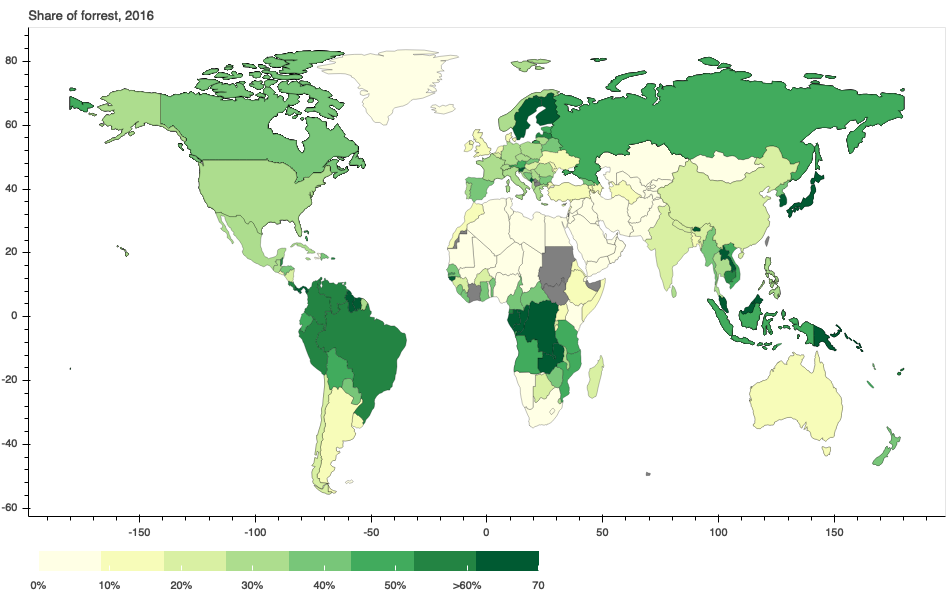

In [9]:
# since we use BokehJS to make the interactive plot, it probably would not be shown if readers do not install these libraries
# thus, we show the saved image here 
from IPython.display import Image
Image('./data/images/share-of-forrest-2016.png')

Next, from the broader view, we would like to check the forest areas in each continent.

In [7]:
# forest areas in continents over years
continents_forests_area = land_use_all[land_use_all.Item.isin(LAND_USE_FOREST_ITEMS) &   
                                       land_use_all.Element.str.match('Area') & 
                                       land_use.Area.isin(CONTINENTS)].groupby(["Area", "Year"]).Value.sum()

continents_forests_area_unstack = continents_forests_area.unstack("Year")

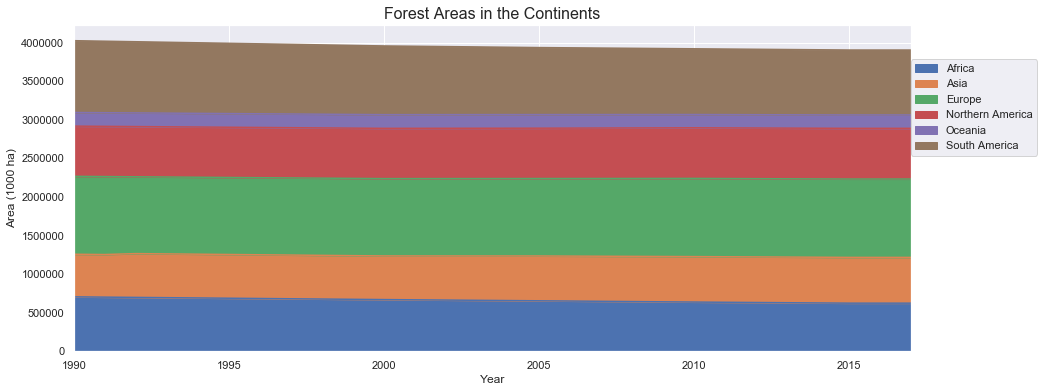

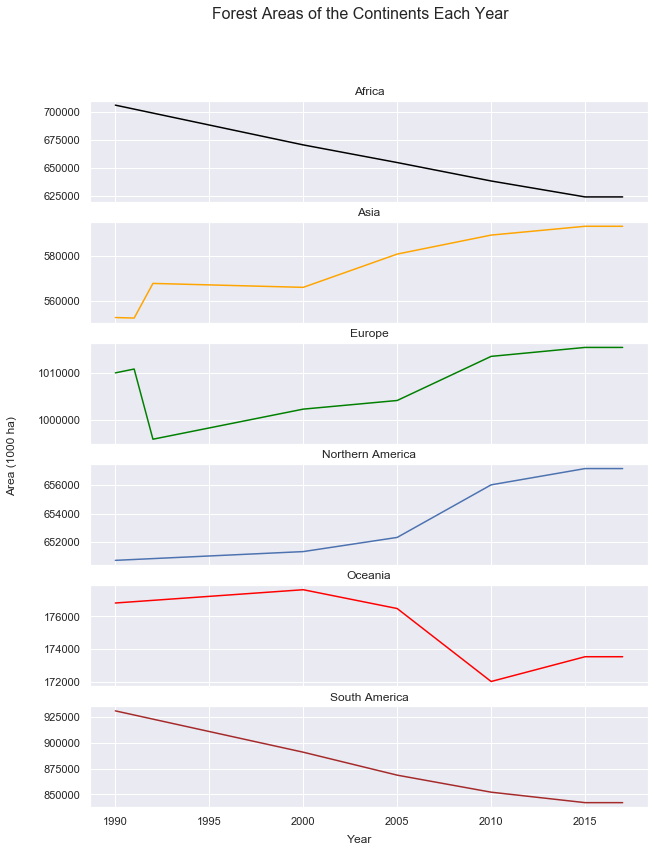

In [8]:
# plot forested areas in continents over the years
continetns_forests_plot = continents_forests_area_unstack.T.plot.area(figsize=(15,6))
plt.legend(loc = (1, 0.6))
plt.ylabel('Area (1000 ha)')
plt.title('Forest Areas in the Continents', fontsize = 16)
plt.show()

# look deeper for each continent
fig, axes = plt.subplots(6, 1, sharex = True, figsize = (10, 13))
axes[0].plot(continents_forests_area.loc['Africa'], color = 'black')
axes[1].plot(continents_forests_area.loc['Asia'], color = 'orange')
axes[2].plot(continents_forests_area.loc['Europe'], color = 'green')
axes[3].plot(continents_forests_area.loc['Northern America'])
axes[4].plot(continents_forests_area.loc['Oceania'], color = 'red')
axes[5].plot(continents_forests_area.loc['South America'], color = 'brown')
axes[0].set_title('Africa')
axes[1].set_title('Asia')
axes[2].set_title('Europe')
axes[3].set_title('Northern America')
axes[4].set_title('Oceania')
axes[5].set_title('South America')
fig.suptitle("Forest Areas of the Continents Each Year", fontsize = 16)
fig.text(0.5, 0.087, 'Year', ha = 'center', fontsize = 12)
fig.text(0.01, 0.5, 'Area (1000 ha)', va = 'center', rotation = 'vertical', fontsize = 12)
plt.show()

> #### ***Explanation***
- From the plot, both Africa and South America steadily reduce their forest area over the years.
- Similarly but slightly bizarrely, we can see that the trend in Oceania went upward at first (until 2000) but then dropped sharply in 2005. We doubt that there may be some interesting factors causing this phenomenon.
- In contrast, the rest such as Asia, Europe, and North America continually enlarges their forest areas.

As in many real-world datasets, we encountered the missing values here. Thus, we decided to use median to impute them for each continent.

In [9]:
# replace missing values by median along each column
forested_area_yearly_unstack = forested_area_yearly_unstack.interpolate(axis = 1)

### Deforestation in each country
In this part, we focus on examining the reduction of forests in every country from 1990 to 2017. Mainly we would like to compare the reduction between the first year and the last year.

In [10]:
# helpful functions to extract first and last non-null values
def first(x):
    if x.first_valid_index() is None:
        return None
    else:
        return x[x.first_valid_index()]
    
def last(x):
    if x.last_valid_index() is None:
        return None
    else:
        return x[x.last_valid_index()]

In [11]:
# top 5 countries which have deforestated most of forested areas over these years
forested_areas_diff = forested_area_yearly_unstack.apply(first, axis=1) - forested_area_yearly_unstack.apply(last, axis=1)
forested_areas_diff = forested_areas_diff.sort_values(ascending=False)
forested_areas_diff.head()

Area
Brazil                53167.0
Russian Federation    34493.9
Indonesia             27535.0
Nigeria               10241.0
Myanmar               10177.0
dtype: float64

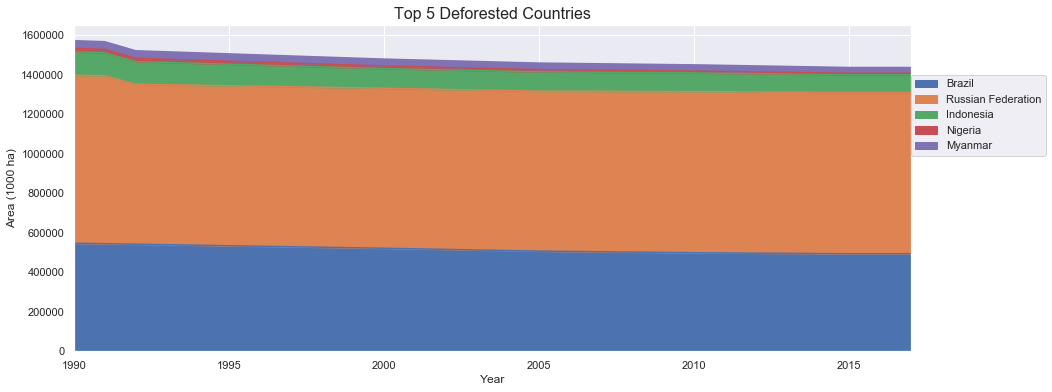

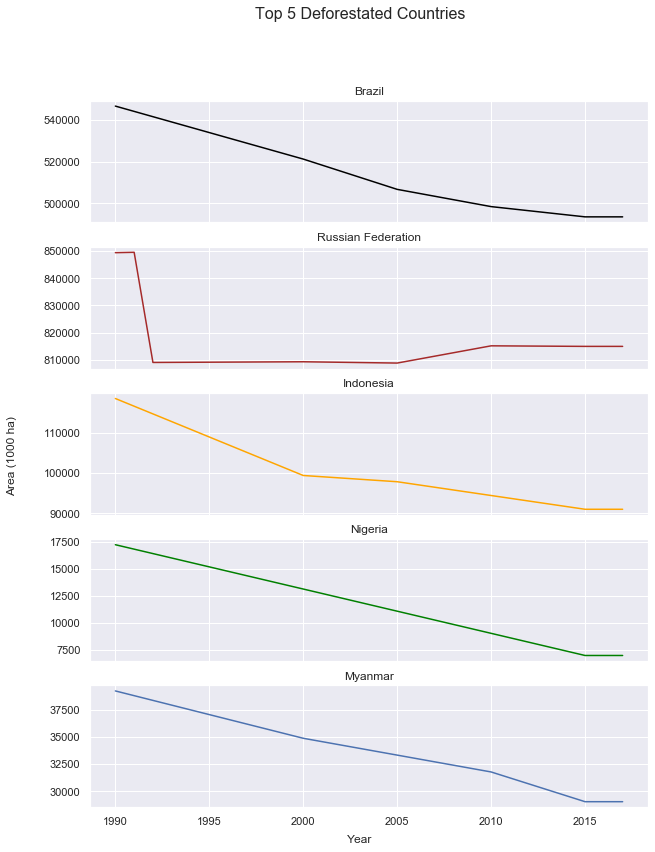

In [12]:
# top 5 countries which have deforestated most of forested areas over the years
forested_area_yearly_unstack.loc[forested_areas_diff.head().index]\
                    .T.plot.area(figsize=(15,6))
plt.legend(loc = (1, 0.6))
plt.title('Top 5 Deforested Countries', fontsize = 16)
plt.ylabel('Area (1000 ha)')
plt.show()

# look deeper for each country
fig, axes = plt.subplots(5, 1, sharex = True, figsize = (10, 13))
axes[0].plot(forested_area_yearly_unstack.loc['Brazil'], color = 'black')
axes[1].plot(forested_area_yearly_unstack.loc['Russian Federation'], color = 'brown')
axes[2].plot(forested_area_yearly_unstack.loc['Indonesia'], color = 'orange')
axes[3].plot(forested_area_yearly_unstack.loc['Nigeria'], color = 'green')
axes[4].plot(forested_area_yearly_unstack.loc['Myanmar'])
axes[0].set_title('Brazil')
axes[1].set_title('Russian Federation')
axes[2].set_title('Indonesia')
axes[3].set_title('Nigeria')
axes[4].set_title('Myanmar')
fig.suptitle("Top 5 Deforestated Countries", fontsize = 16)
fig.text(0.5, 0.087, 'Year', ha = 'center', fontsize = 12)
fig.text(0.01, 0.5, 'Area (1000 ha)', va = 'center', rotation = 'vertical', fontsize = 12)
plt.show()

> #### ***Explanation***
- We notice that the rapid reduction in Russia is mainly from 1991 to 1992.
- We speculate that the reason why Russia decreased much forests areas at that time is due to the collapse of Soviet Union, shrinking Russia's territory.
- In this case, we remove Russia to exclude the political issue.
- Look for more details, check [**here**](https://en.wikipedia.org/wiki/Dissolution_of_the_Soviet_Union)

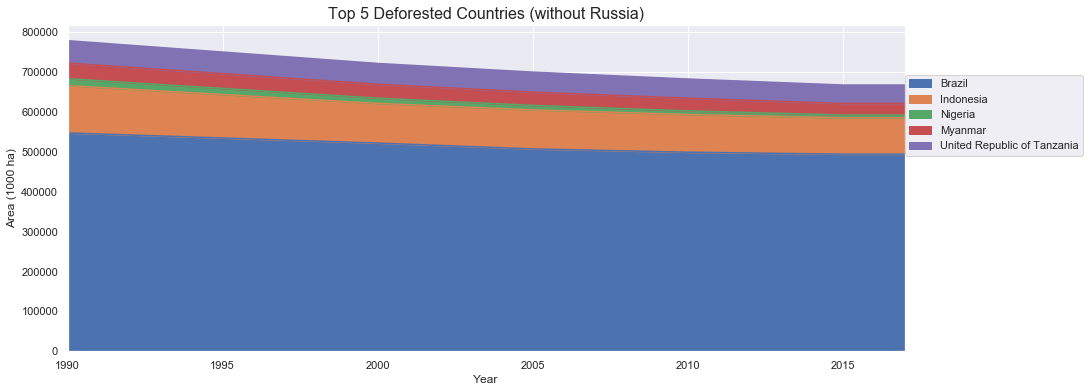

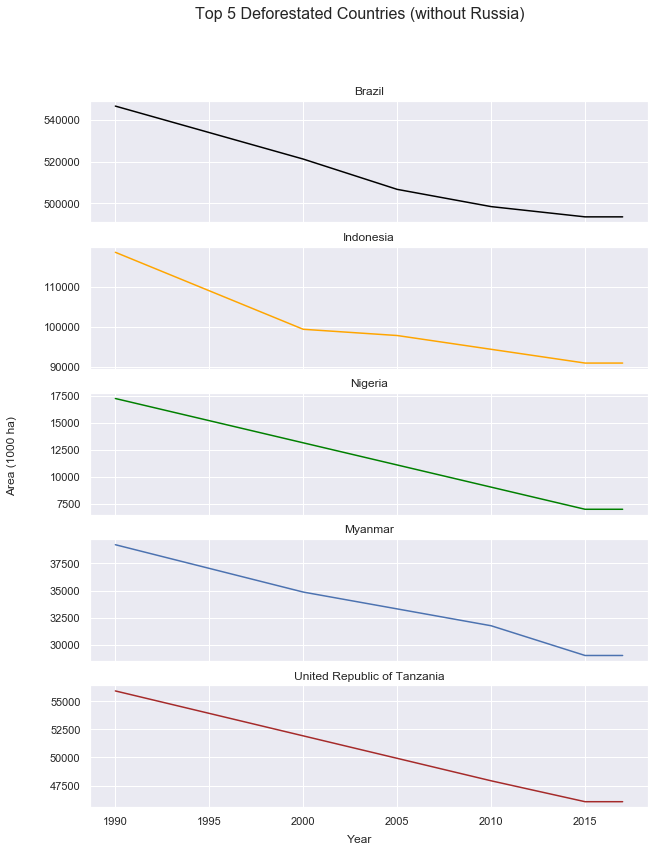

In [13]:
# top 5 countries which have deforestated most of forested areas over the years (without Russia)
forested_area_yearly_unstack.loc[forested_areas_diff[[0, 2, 3, 4, 5]].index]\
                    .T.plot.area(figsize=(15,6))
plt.legend(loc = (1, 0.6))
plt.title('Top 5 Deforested Countries (without Russia)', fontsize = 16)
plt.ylabel('Area (1000 ha)')
plt.show()

# look deeper for each country
fig, axes = plt.subplots(5, 1, sharex = True, figsize = (10, 13))
axes[0].plot(forested_area_yearly_unstack.loc['Brazil'], color = 'black')
axes[1].plot(forested_area_yearly_unstack.loc['Indonesia'], color = 'orange')
axes[2].plot(forested_area_yearly_unstack.loc['Nigeria'], color = 'green')
axes[3].plot(forested_area_yearly_unstack.loc['Myanmar'])
axes[4].plot(forested_area_yearly_unstack.loc['United Republic of Tanzania'], color = 'brown')
axes[0].set_title('Brazil')
axes[1].set_title('Indonesia')
axes[2].set_title('Nigeria')
axes[3].set_title('Myanmar')
axes[4].set_title('United Republic of Tanzania')
fig.suptitle("Top 5 Deforestated Countries (without Russia)", fontsize = 16)
fig.text(0.5, 0.087, 'Year', ha = 'center', fontsize = 12)
fig.text(0.01, 0.5, 'Area (1000 ha)', va = 'center', rotation = 'vertical', fontsize = 12)
plt.show()

> #### ***Explanation***
- As we can see in both plots, these top 5 deforested countries have been all steadily decreasing their forest areas (with almost the same trend).
- At first, Indonesia had more rapid deforestation trend; however, after 2000, the trend slowed down.

In [14]:
# top 5 countries with biggest expansion of forests (Note: Russian Federation seems as an outlier)
forested_areas_diff.tail()

Area
Spain                       -4608.38
Viet Nam                    -5410.00
India                       -6743.00
United States of America    -7645.00
China:mainland             -51180.70
dtype: float64

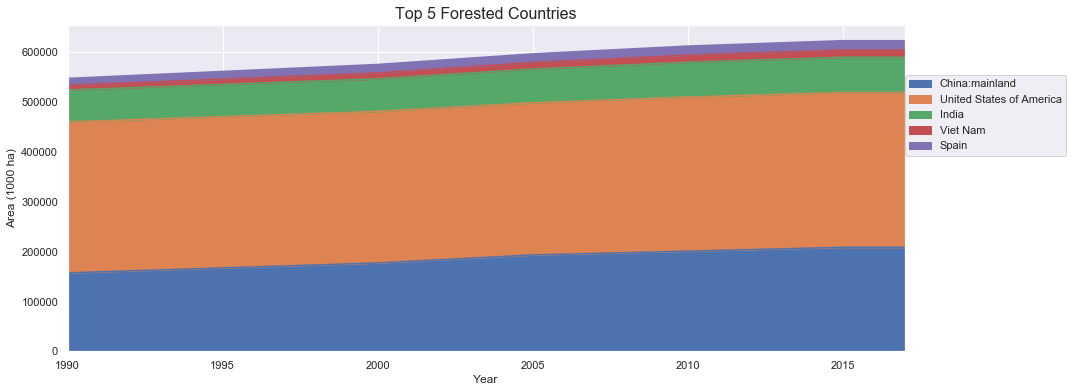

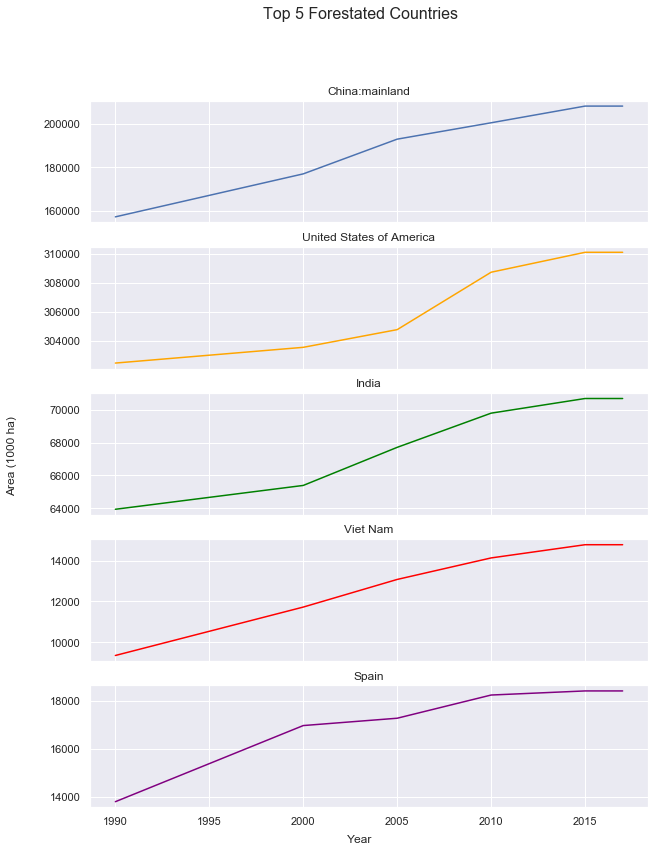

In [15]:
# top 5 countries which have forestated forest areas over the years
forested_area_yearly_unstack.loc[forested_areas_diff.sort_values(ascending= True).head().index]\
                    .T.plot.area(figsize=(15,6))
plt.legend(loc = (1, 0.6))
plt.title('Top 5 Forested Countries', fontsize = 16)
plt.ylabel('Area (1000 ha)')
plt.show()

# look deeper for each country
fig, axes = plt.subplots(5, 1, sharex = True, figsize = (10, 13))
axes[0].plot(forested_area_yearly_unstack.loc['China:mainland'])
axes[1].plot(forested_area_yearly_unstack.loc['United States of America'], color = 'orange')
axes[2].plot(forested_area_yearly_unstack.loc['India'], color = 'green')
axes[3].plot(forested_area_yearly_unstack.loc['Viet Nam'], color = 'red')
axes[4].plot(forested_area_yearly_unstack.loc['Spain'], color = 'purple')
axes[0].set_title('China:mainland')
axes[1].set_title('United States of America')
axes[2].set_title('India')
axes[3].set_title('Viet Nam')
axes[4].set_title('Spain')
fig.suptitle("Top 5 Forestated Countries", fontsize = 16)
fig.text(0.5, 0.087, 'Year', ha = 'center', fontsize = 12)
fig.text(0.01, 0.5, 'Area (1000 ha)', va = 'center', rotation = 'vertical', fontsize = 12)
plt.show()

> #### ***Explanation***
- Suprisingly, most of top 5 countries with fast-growing forest areas are developing countries such as China, India, and Vietnam.
- Let's dig more information why this phenonmen occurs.

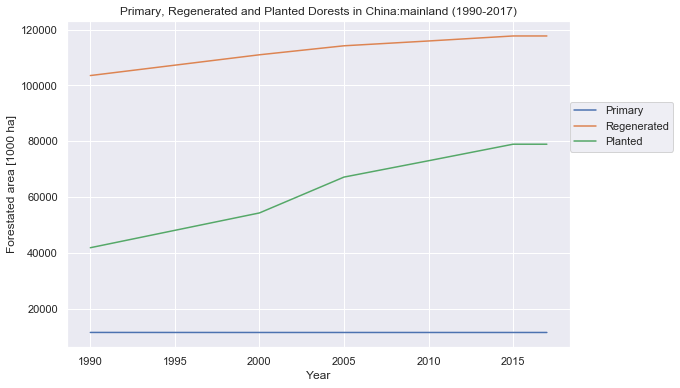

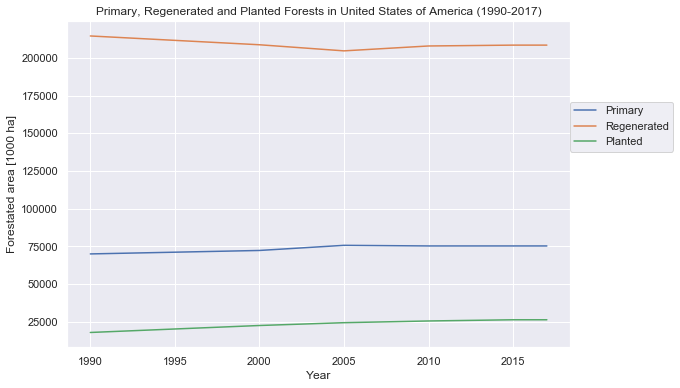

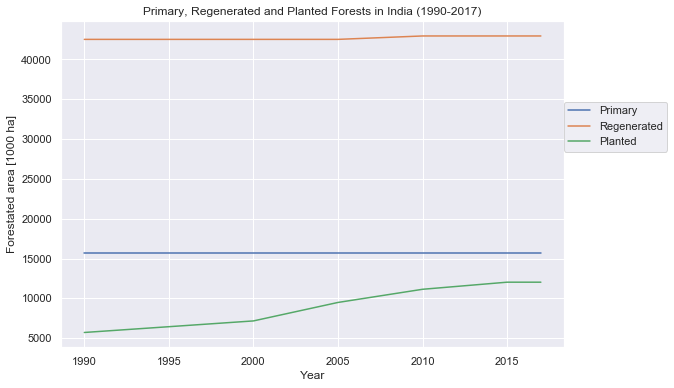

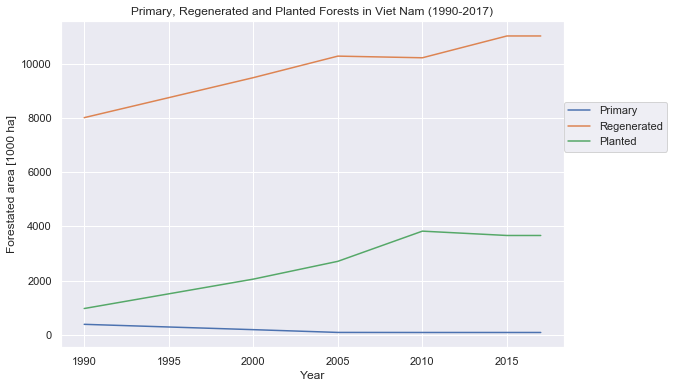

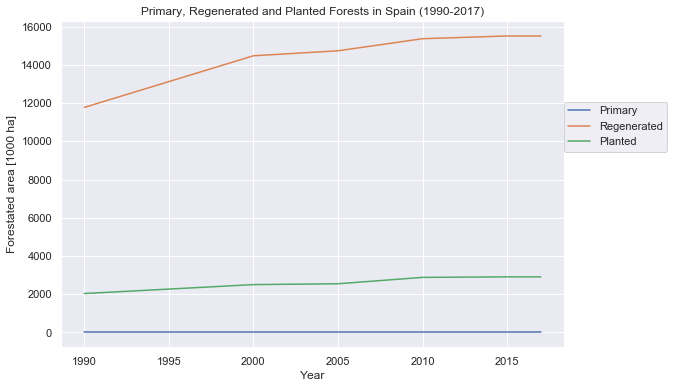

In [17]:
# plot the three kinds of forest (primary, regenerated and planted) for the selected country
# select some important features
LAND_USE_PARTIAL_FOREST_ITEMS = ['Primary Forest', 'Other naturally regenerated forest', 'Planted Forest']
land_use_detail = land_use_all[land_use_all.Item.isin(LAND_USE_PARTIAL_FOREST_ITEMS) &
                        land_use_all.Element.str.match('Area')]

# plot the detail forestation info of China
COUNTRY = 'China:mainland'
country_partial_forested_area = land_use_detail.loc[(land_use_all['Item'].isin(LAND_USE_PARTIAL_FOREST_ITEMS)) &
                                             (land_use_all['Area'] == COUNTRY)]

plt.figure(figsize=(9, 6))
for forest_type in LAND_USE_PARTIAL_FOREST_ITEMS:
    plt.plot(country_partial_forested_area.loc[country_partial_forested_area['Item'] == forest_type]['Year'],
             country_partial_forested_area.loc[country_partial_forested_area['Item'] == forest_type]['Value'])
plt.title('Primary, Regenerated and Planted Dorests in ' + COUNTRY + ' (1990-2017)')
plt.legend(['Primary', 'Regenerated', 'Planted'], loc = (1, 0.6))
plt.gca().set_xlabel('Year')
plt.gca().set_ylabel('Forestated area [1000 ha]')
plt.show()

# plot the detail forestation info of USA
COUNTRY = 'United States of America'
country_partial_forested_area = land_use_detail.loc[(land_use_all['Item'].isin(LAND_USE_PARTIAL_FOREST_ITEMS)) &
                                             (land_use_all['Area'] == COUNTRY)]

plt.figure(figsize=(9, 6))
for forest_type in LAND_USE_PARTIAL_FOREST_ITEMS:
    plt.plot(country_partial_forested_area.loc[country_partial_forested_area['Item'] == forest_type]['Year'],
             country_partial_forested_area.loc[country_partial_forested_area['Item'] == forest_type]['Value'])
plt.title('Primary, Regenerated and Planted Forests in ' + COUNTRY + ' (1990-2017)')
plt.legend(['Primary', 'Regenerated', 'Planted'], loc = (1, 0.6))
plt.gca().set_xlabel('Year')
plt.gca().set_ylabel('Forestated area [1000 ha]')
plt.show()

# plot the detail forestation info of India
COUNTRY = 'India'
country_partial_forested_area = land_use_detail.loc[(land_use_all['Item'].isin(LAND_USE_PARTIAL_FOREST_ITEMS)) &
                                             (land_use_all['Area'] == COUNTRY)]

plt.figure(figsize=(9, 6))
for forest_type in LAND_USE_PARTIAL_FOREST_ITEMS:
    plt.plot(country_partial_forested_area.loc[country_partial_forested_area['Item'] == forest_type]['Year'],
             country_partial_forested_area.loc[country_partial_forested_area['Item'] == forest_type]['Value'])
plt.title('Primary, Regenerated and Planted Forests in ' + COUNTRY + ' (1990-2017)')
plt.legend(['Primary', 'Regenerated', 'Planted'], loc = (1, 0.6))
plt.gca().set_xlabel('Year')
plt.gca().set_ylabel('Forestated area [1000 ha]')
plt.show()

# plot the detail forestation info of Vietnam
COUNTRY = 'Viet Nam'
country_partial_forested_area = land_use_detail.loc[(land_use_all['Item'].isin(LAND_USE_PARTIAL_FOREST_ITEMS)) &
                                             (land_use_all['Area'] == COUNTRY)]

plt.figure(figsize=(9, 6))
for forest_type in LAND_USE_PARTIAL_FOREST_ITEMS:
    plt.plot(country_partial_forested_area.loc[country_partial_forested_area['Item'] == forest_type]['Year'],
             country_partial_forested_area.loc[country_partial_forested_area['Item'] == forest_type]['Value'])
plt.title('Primary, Regenerated and Planted Forests in ' + COUNTRY + ' (1990-2017)')
plt.legend(['Primary', 'Regenerated', 'Planted'], loc = (1, 0.6))
plt.gca().set_xlabel('Year')
plt.gca().set_ylabel('Forestated area [1000 ha]')
plt.show()

# plot the detail forestation info of Spain
COUNTRY = 'Spain'
country_partial_forested_area = land_use_detail.loc[(land_use_all['Item'].isin(LAND_USE_PARTIAL_FOREST_ITEMS)) &
                                             (land_use_all['Area'] == COUNTRY)]

plt.figure(figsize=(9, 6))
for forest_type in LAND_USE_PARTIAL_FOREST_ITEMS:
    plt.plot(country_partial_forested_area.loc[country_partial_forested_area['Item'] == forest_type]['Year'],
             country_partial_forested_area.loc[country_partial_forested_area['Item'] == forest_type]['Value'])
plt.title('Primary, Regenerated and Planted Forests in ' + COUNTRY + ' (1990-2017)')
plt.legend(['Primary', 'Regenerated', 'Planted'], loc = (1, 0.6))
plt.gca().set_xlabel('Year')
plt.gca().set_ylabel('Forestated area [1000 ha]')
plt.show()

> #### ***Explanation***
- From our investigation of three main types of forests, we observed that the reason why China could enlarge their forests is because of increasing planted trees by its people and naturally regenerated trees every year.
- For USA, increasing cause is due to the growing number of naturally regenerated trees.
- Starting from 2000, India has been rising its number of planted trees to expand its forest areas.
- As for Vietnam, it had expanded stablily its planted trees and regenerated trees in every coming year; however, since 2010, the growing trend has stopped and remains the same.
- Lastly, the main reason why Spain has expanding forest areas is that naturally regenerated trees grow every year.

In this section, we try to research on the dataset `Environment_LandUse_E_All_Data_cleared.csv` to find out ***percentage*** of forestation and deforestation in each country. Still, we would like to figure out the trend of deforestation in percentage over the time span in each country.

In [16]:
# load ENV LansUse and select share of the forests in the each Area per yesr 
ENV_LAND_USE_FOREST = ['Forest land', 'Primary Forest', 'Planted Forest', 
                       'Other naturally regenerated forest']

env_land_use_all = pd.read_csv("data/faostat/Environment_LandUse_E_All_Data_cleared.csv", engine='python')

env_land_use = env_land_use_all[env_land_use_all.Item.isin(ENV_LAND_USE_FOREST) & env_land_use_all.Element.str.match("Share in Land area")]

env_land_use_yearly = env_land_use.groupby(["Area", "Year"]).Value.sum()
env_land_use_yearly = env_land_use_yearly.unstack("Year").fillna(method="backfill", axis=0)

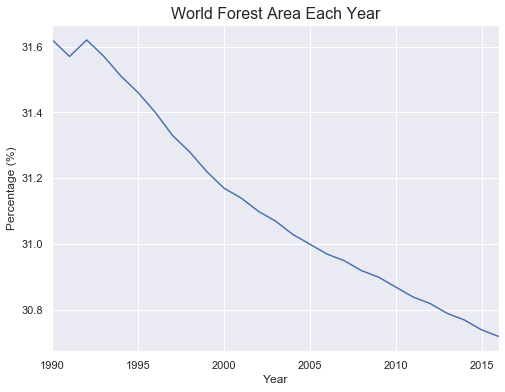

In [17]:
# plot the percentage of world forest areas 
env_land_use_yearly.loc['World'].plot(figsize = (8, 6))
plt.title('World Forest Area Each Year', fontsize = 16)
plt.ylabel('Percentage (%)')
plt.show()

> #### ***Explanation***
- Sadly, the world forest percentage is continuously decreasing, and it has dropped almost 1 percent since 1990s.
- More specifically, total deforestation area around the world is equivalent to almost 30 times the territory of Switzerland.

In [18]:
# compute the percentage of deforestation for each country
env_land_use_diff = env_land_use_yearly[env_land_use_yearly.index.isin(FAOSTAT_countries)].iloc[:, 0]\
                                        - env_land_use_yearly[env_land_use_yearly.index.isin(FAOSTAT_countries)].iloc[:, -1]

env_land_use_diff = env_land_use_diff.sort_values(ascending=False)

In [19]:
# top 5 countries which have deforestated by % of deforestated areas
env_land_use_diff.head()

Area
Pacific Islands Trust Territory    80.36
Serbia                             57.29
Azerbaijan                         37.35
Honduras                           32.74
USSR                               29.07
dtype: float64

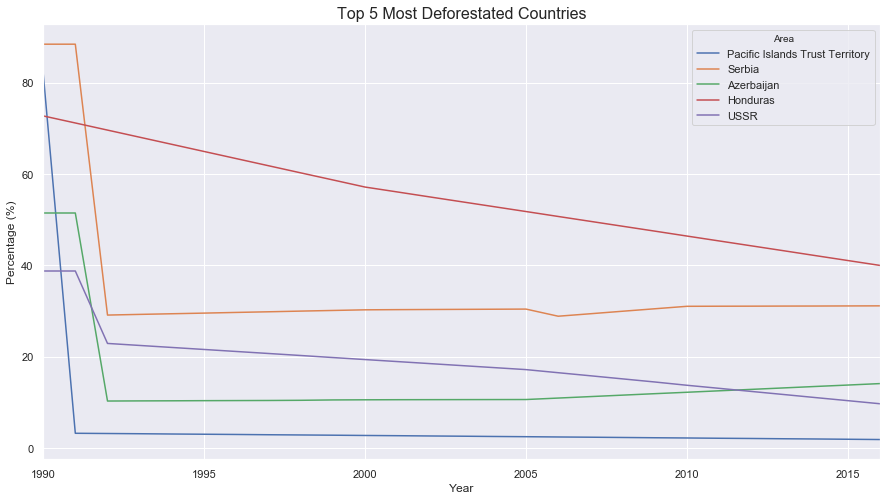

In [20]:
# plot the top 5 countries with most deforestation
env_land_use_yearly.loc[env_land_use_diff.head().index].T.plot(figsize=(15,8))
plt.title('Top 5 Most Deforestated Countries', fontsize = 16)
plt.ylabel('Percentage (%)')
plt.show()

> #### ***Explanation***
- Interestingly, top 5 countries except Honduras had decreased their forest percentage during early 1900s, and after that, these percentages remain stable to 2017.
- Honduras has been steadily reducing its forestated areas since 1990.

In [21]:
# show top 5 least deforested countries
env_land_use_diff.tail()

Area
Belgium-Luxembourg                 -36.43
Russian Federation                 -36.87
Micronesia (Federated States of)   -42.36
Netherlands Antilles (former)      -44.42
Sudan (former)                     -85.33
dtype: float64

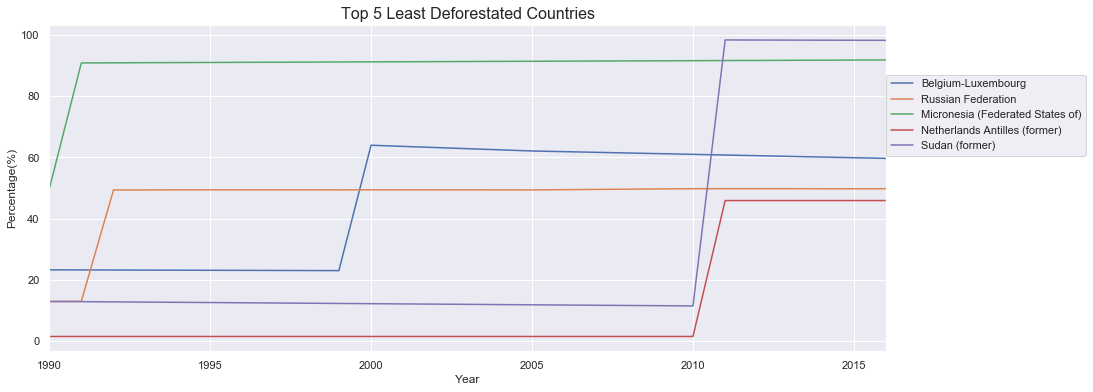

In [22]:
# plot the line graph to show the trend
env_land_use_yearly.loc[env_land_use_diff.tail().index].T.plot(figsize=(15,6))
plt.title('Top 5 Least Deforestated Countries', fontsize = 16)
plt.ylabel('Percentage(%)')
plt.legend(loc = (1, 0.6))
plt.show()

> #### ***Explanation***
- We could observe that instead of growing steadily, the trends of all top 5 deforestated countries have a sudden jump in different times, making their forest areas change rapidly within few years. 

### Environment_LandCover_E_All_Data_cleared.csv

In [29]:
# load ENV landCover and select tree covered areas (per country per year) and split them by origin
env_land_cover_all = pd.read_csv("data/faostat/Environment_LandCover_E_All_Data_cleared.csv", engine='python')

env_land_cover_MODIS = env_land_cover_all[env_land_cover_all.Item.str.match("Tree-covered areas") & env_land_cover_all.Element.str.match("Area from MODIS")]\
                                         .groupby(["Area", "Year"])\
                                         .Value.sum()\
                                         .unstack("Year")\
                                         .fillna(method="backfill")

env_land_cover_CCI_LC = env_land_cover_all[env_land_cover_all.Item.str.match("Tree-covered areas") & env_land_cover_all.Element.str.match("Area from CCI_LC")]\
                                          .groupby(["Area", "Year"])\
                                          .Value.sum()\
                                          .unstack("Year")\
                                          .fillna(method="backfill")

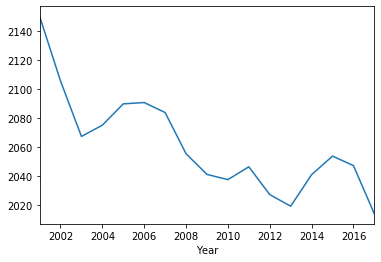

In [30]:
# plot forest in Switzerland per year base on the MODIS data
env_land_cover_MODIS.loc["Switzerland"].plot()
plt.show()

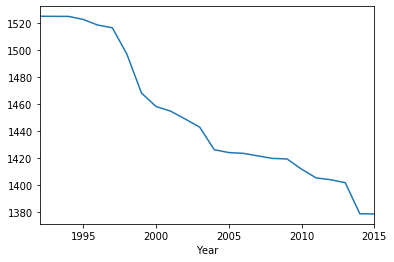

In [31]:
# plot forest are in Switzerland per year base on the CCI_LC data
env_land_cover_CCI_LC.loc["Switzerland"].plot()
plt.show()

#### Note to the CCI_LC & MODIS
**MODIS** data are only from the year 2001, they seem to differ from the **CCI_LC** data.


## 2. The Wood Trade
Now, based on `data/faostat/Forestry_E_All_Data_cleared.csv` and `data/faostat/Forestry_Trade_Flows_E_All_Data_cleared.csv`, we start to look for the biggest producers and consumers of the wood in the world.

In [32]:
# load Forestry data
forest_all = pd.read_csv("data/faostat/Forestry_E_All_Data_cleared.csv", engine='python')
forest_trade = pd.read_csv("data/faostat/Forestry_Trade_Flows_E_All_Data_cleared.csv", engine='python')

In [35]:
forest_all.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,1877,Forest products (export/import),5622,Import Value,1964,1964,1000 US$,301.0,A
1,2,Afghanistan,1877,Forest products (export/import),5622,Import Value,1965,1965,1000 US$,321.0,A
2,2,Afghanistan,1877,Forest products (export/import),5622,Import Value,1966,1966,1000 US$,435.0,A
3,2,Afghanistan,1877,Forest products (export/import),5622,Import Value,1967,1967,1000 US$,466.0,A
4,2,Afghanistan,1877,Forest products (export/import),5622,Import Value,1968,1968,1000 US$,297.0,A


In [36]:
forest_trade.head()

,Reporter Country Code,Reporter Countries,Partner Country Code,Partner Countries,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,10,Australia,1877,Forest products (export/import),5622,Import Value,1999,1999,1000 US$,6.0,NaN
1,2,Afghanistan,10,Australia,1877,Forest products (export/import),5622,Import Value,2005,2005,1000 US$,18.0,NaN
2,2,Afghanistan,10,Australia,1877,Forest products (export/import),5622,Import Value,2009,2009,1000 US$,59.0,NaN
3,2,Afghanistan,10,Australia,1877,Forest products (export/import),5622,Import Value,2015,2015,1000 US$,5.0,NaN
4,2,Afghanistan,10,Australia,1640,Plywood,5616,Import Quantity,1999,1999,m3,5.0,R


In [33]:
# the wood production of countries in m3
wood_production_m3 = forest_all[forest_all.Element.str.match("Production") & 
                                forest_all.Area.isin(FAOSTAT_countries) & 
                                forest_all.Unit.str.match("m3")]\
                                .groupby(["Area", "Year"])\
                                .Value.sum().unstack("Year")

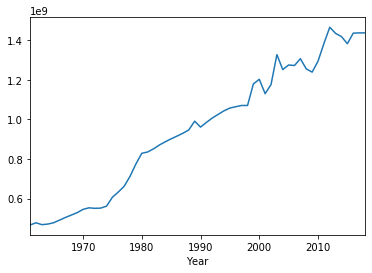

In [34]:
# the wood production of Brazil in m3
wood_production_m3.loc["Brazil"].plot()
plt.show()

In [39]:
# the biggest producer of wood in 2018
wood_production_m3.loc[:, 2018].sort_values(ascending=False).head(20)

Area
United States of America            2.862400e+09
China:mainland                      2.546835e+09
Russian Federation                  1.589406e+09
India                               1.534867e+09
Brazil                              1.436541e+09
Canada                              1.137304e+09
Indonesia                           6.445435e+08
Sweden                              5.032570e+08
Germany                             5.022776e+08
Ethiopia                            4.603311e+08
Finland                             4.588330e+08
Chile                               3.923023e+08
Democratic Republic of the Congo    3.662536e+08
Poland                              3.358665e+08
Nigeria                             3.278924e+08
France                              3.142304e+08
Australia                           2.710942e+08
Viet Nam                            2.454429e+08
Japan                               2.147920e+08
Mexico                              2.122413e+08
Name: 2018, dty

In [40]:
wood_production_tonnes = forest_all[forest_all.Element.str.match("Production") & 
                                forest_all.Area.isin(FAOSTAT_countries) & 
                                forest_all.Unit.str.match("tonnes")]\
                                .groupby(["Area", "Year"])\
                                .Value.sum().unstack("Year")

In [41]:
wood_production_tonnes.loc[:, 2018].sort_values(ascending=False).head(20)

Area
China:mainland              819880071.0
United States of America    790735011.0
Japan                       226970000.0
Brazil                      205199800.0
Germany                     168215554.0
Canada                      143986343.0
Sweden                      125128144.0
Indonesia                   121407968.0
Finland                     117565447.0
India                       117236100.0
Russian Federation          109286772.0
Republic of Korea            82557000.0
France                       72289261.0
Italy                        65448173.0
Spain                        57385168.0
Thailand                     46048810.0
Mexico                       45740000.0
Austria                      45225485.0
Poland                       43051108.0
Chile                        38294775.0
Name: 2018, dtype: float64

In [42]:
# wood export of countries per year in m3
wood_export_m3 = forest_all[forest_all.Element.str.match("Export Quantity") & 
                            forest_all.Unit.str.match("m3") & 
                            forest_all.Area.isin(FAOSTAT_countries)]\
                           .groupby(["Area", "Year"])\
                           .Value.sum()\
                           .unstack("Year")


In [43]:
wood_export_tonnes = forest_all[forest_all.Element.str.match("Export Quantity") & 
                                forest_all.Unit.str.match("tonnes") & 
                                forest_all.Area.isin(FAOSTAT_countries)]\
                                .groupby(["Area", "Year"])\
                                .Value.sum()\
                                .unstack("Year")


In [44]:
wood_export_m3.loc[:, 2018].sort_values(ascending=False).head(10)


Area
Russian Federation          159085467.0
Canada                      108484104.0
New Zealand                 100992260.0
United States of America     83218571.0
Germany                      60288070.0
Australia                    46625726.0
Czechia                      35948676.0
Poland                       33188613.0
Viet Nam                     31409440.0
France                       29555247.0
Name: 2018, dtype: float64

In [45]:
wood_export_tonnes.loc[:, 2018].sort_values(ascending=False).head(10)


Area
United States of America    160562185.0
Canada                       98102389.0
Brazil                       92900134.0
Germany                      90893070.0
Finland                      77437050.0
Sweden                       71448776.0
Indonesia                    49749723.0
China:mainland               33079734.0
Russian Federation           32694767.0
Chile                        29571144.0
Name: 2018, dtype: float64

In [46]:
forest_trade.Element.unique


<bound method Series.unique of 0             Import Value
1             Import Value
2             Import Value
3             Import Value
4          Import Quantity
                ...       
2689550       Import Value
2689551       Import Value
2689552       Import Value
2689553       Import Value
2689554       Import Value
Name: Element, Length: 2689555, dtype: object>

## 2. Is agricultural industry influencing deforestation? 
One of the most negative influences on the deforestation might have an agricultural industry. We've decided to investigate this possible connection.

In [ ]:
#TODO

## 3. Is breeding farm animals influencing deforestation? 
Breeding animals might be space consumig, we've searched for the origin of the land used for this purpose.


In [ ]:
#TODO

## 4. Future Plan
-